# Clasificación de volcanes  

![Volcanes](https://challenges-asset-files.s3.us-east-2.amazonaws.com/data_sets/Data-Science/4+-+events/jobmadrid/images/front.png)  

### Descripción del reto

> Jorge es un geólogo del IGME (Instituto Geológico y Minero de España) que está desarrollando un nuevo sistema de prevención de erupciones para poder predecir qué tipo de erupción tendrá un volcán según las las vibraciones detectadas por sus sensores durante los días previos a la erupción. Esto permitirá reducir el riesgo de víctimas y destrozos materiales por este tipo de catástrofe natural.
El sistema de Jorge trabaja con 5 tipos de erupciones:  


> - **Pliniana**: Se caracteriza por su alto grado de explosividad, con manifestaciones muy violentas en las cuales se expulsan grandes volúmenes de gas volcánico, fragmentos y cenizas.

> - **Peleana:** La característica más importante de una erupción peleana es la presencia de una avalancha brillante de ceniza volcánica caliente, llamada flujo piroclástico.

> - **Vulcaniana:** Son erupciones volcánicas de tipo explosivo. El material magmático liberado es más viscoso que en el caso de las erupciones hawaianas o estrombolianas; consecuentemente, se acumula más presión desde la cámara magmática conforme el magma asciende hacia la superficie.

> - **Hawaiana:** Consiste en la emisión de material volcánico, mayoritariamente basáltico, de manera efusiva o no explosiva. Ocurre de este modo debido a que la difusión de los gases a través de magmas más básicos (basálticos) puede hacerse de manera lenta pero más o menos continua. Consecuentemente, las erupciones volcánicas de este tipo no suelen ser muy destructivas.

> - **Estromboliana:** La erupción Estromboliana está caracterizada por erupciones explosivas separadas por periodos de calma de duración variable. El proceso de cada explosión corresponde a la evolución de una burbuja de gases liberados por el propio magma.

### Importación de librerias necesarias

In [1]:
# Analisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from imblearn.ensemble import BalancedRandomForestClassifier
from collections import Counter
from imblearn.over_sampling import SMOTE


# Metricas
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# Otras
import warnings
warnings.filterwarnings("ignore")


### Carga de datos iniciales

En primer lugar, se realiza la carga de los datos en un dataframe de Pandas y se muestran las primeras filas

In [2]:
df_volcanes = pd.read_csv("jm_train.csv")
df_volcanes.head()

,feature1,feature2,feature3,feature4,feature5,feature6,target
0,0.474335,0.881640,-2.050543,-1.251935,-1.035151,-1.934367,4
1,-1.034675,1.741801,-1.660629,-1.555989,-0.337553,-2.473838,0
2,-0.563221,-0.688381,-0.318415,-1.845172,0.352366,-0.912928,1
3,-1.268179,2.770688,1.054193,2.830389,0.395093,0.677715,3
4,-1.216380,-0.391267,-2.898931,-0.913074,-2.171857,-2.367490,0


### Análisis exploratorio de los datos (EDA)  

En primer lugar, se comprueba la cantidad de datos que tiene el dataset, tanto el número de registros, como el número de variables (columnas). Tras esto, se procede a comprobar si, el conjunto de datos, contiene valores perdidos, cuántos y en qué variables se encuentran.

In [3]:
# Total de registros y variables
print(f"El dataset contiene {df_volcanes.shape[0]} registros y {df_volcanes.shape[1]} variables")

El dataset contiene 2100 registros y 7 variables


In [4]:
# Comprobación de nulos
df_volcanes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  2100 non-null   float64
 1   feature2  2100 non-null   float64
 2   feature3  2100 non-null   float64
 3   feature4  2100 non-null   float64
 4   feature5  2100 non-null   float64
 5   feature6  2100 non-null   float64
 6   target    2100 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 115.0 KB


Tal y como se puede ver, no existen valores perdidos en ninguna variable. Además, la ejecución de la instrucción muestra los tipos de datos de cada variable. Todas ellas son de tipo float mientras que el *target* es de tipo int, como cabia esperar. A continuación se procede a mostrar el conjunto de estadísticos básicos.

In [5]:
df_volcanes.describe()

,feature1,feature2,feature3,feature4,feature5,feature6,target
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,-0.204656,0.199249,-0.378140,-0.206425,-0.186419,-0.433229,1.980476
std,1.543613,1.614024,1.450548,1.442225,1.501573,1.188791,1.410537
min,-6.683655,-5.383371,-6.147055,-5.653594,-5.912521,-4.433189,0.000000
25%,-1.171340,-0.877386,-1.365990,-1.259403,-1.211685,-1.131944,1.000000
50%,-0.443868,0.320507,-0.439745,-0.176504,-0.195751,-0.406754,2.000000
75%,0.890023,1.321430,0.662898,0.866879,0.851843,0.348593,3.000000
max,4.565547,6.700133,4.157518,4.371912,5.068783,4.016324,4.000000


Referente a los estadísticos, no hay mucha información reelevante que pueda comentarse. Algunos datos que se podrían destacar como curiosidad son que, los mínimos de las variables fluctúan entre -6.68 y -4.43 siéndo los máximos similares pero de signo positivo. Por otro lado en cuanto al *target* se puede ver que mínimo es de 0 y máximo 4, cosa que concuerda con cada una de las clases a predecir. Como se comentaba anteriormente, no se encuentran datos que merezcan una atención especial.

A continuación se comprueba si los datos estan o no balanceados, es decir, si la representación de alguna de las clases a predecir (*target*) es muy elevada, en número, con respecto a otras. Una forma sencilla de poder comprobar este aspecto es mediante una gráfica de barras.

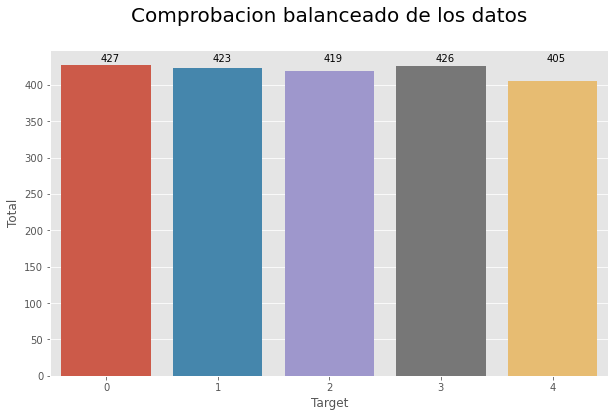

In [6]:
plt.figure(figsize=(10,6))
ax = sns.countplot(df_volcanes['target'])
ax.set_title("Comprobacion balanceado de los datos\n", fontsize=20)
ax.set_xlabel('Target')
ax.set_ylabel('Total')

# Posicionamiento de las anotaciones de las barras
maxValueBars = max([bar.get_height() for bar in ax.patches]) # Se extrae el valor máximo
for val in ax.patches:
    ax.text((val.get_x()-0.05 + val.get_width()/2), maxValueBars + 5, f'{val.get_height()}')
plt.show()

El gráfico permite ver con facilidad que las clases tienen una representación similar en el conjunto de datos. De todos modos, se implementará algún modelo con equilibrado de clases por si se logra una mejora en las predicciones.

También es interesante ver cómo están distribuidos los datos dentro de cada una de las variables, excluyendo el *target*. Para ello se presentan las siguientes graficas de densidad, donde muestran claramente la distribución que toman los datos.

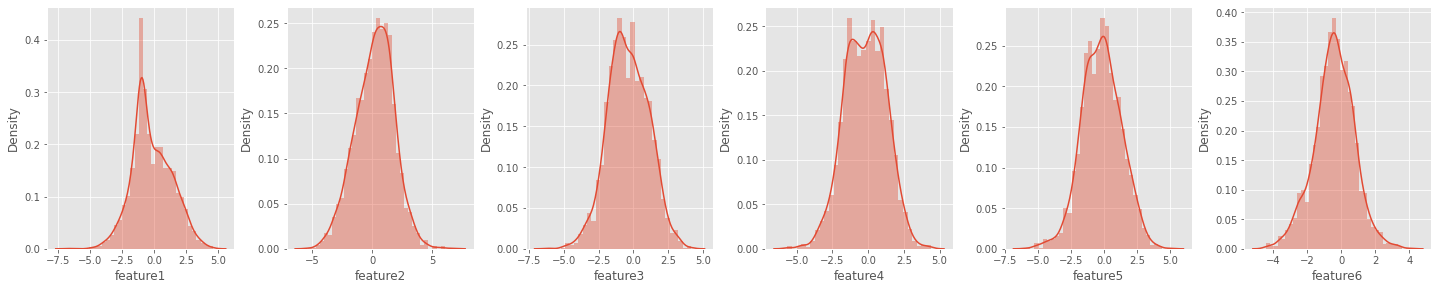

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(20,4))
ax = ax.flatten()
for x, i in enumerate(df_volcanes.iloc[:,:-1]):
    sns.distplot(df_volcanes[i], ax=ax[x])
plt.tight_layout(pad=0.6)
plt.show()

Se puede ver claramente que los datos muestran distribuciones similares a una distribución normal. Finalmente, otra observación útil, hace referencia a la presencia, o no, de *outliers*. También, para observar fácilmente este aspecto, se procede a representar gráficamente los datos en *boxplots*.

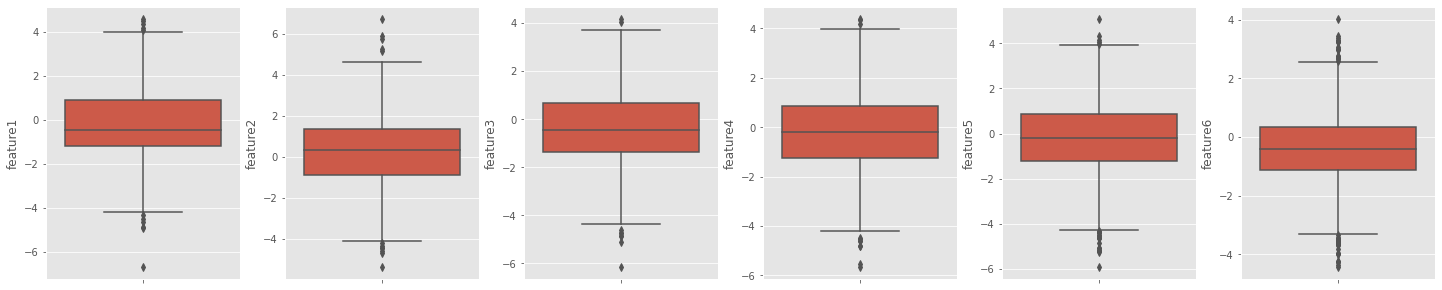

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(20, 4))
ax = ax.flatten()
for x, i in enumerate(df_volcanes.iloc[:,:-1]):
    sns.boxplot(data=df_volcanes, y=i, ax=ax[x])
plt.tight_layout(pad=0.6)
plt.show()

Tras visualizar las gŕaficas, se puede ver que existen algunos *outliers* en algunas de las variables. Random Forest no se ve muy influenciado por los *outliers*. De todos modos, se realizarán modelos con y sin estos valores. Para detectarlos se calcula el rango intercuartilico(iqr) que es la diferencia entre el cuartil 3 y el cuartil 1. Se consideran *outliers* aquellos datos que se encuentren 1.5 veces por encima o por debajo del iqr.

In [9]:
# Detectar outliers
# Calculo del rango intercuartilico
def eliminar_outliers(df):
    '''
    Funcion que calcula el rango intercuartilico (iqr) y elimina aquellos valores alejados 1.5 desviaciones del iqr
    
    Parametros: El dataframe original
    
    Retorna: El dataframe sin los outliers
    '''
    q1, q3 = df.quantile(0.25), df.quantile(0.75)
    iqr = q3-q1
    lower, upper = q1-1.5*iqr, q3+1.5*iqr
    # Filtrado de outliers
    df_sinOutliers = df[~((df<lower) | (df>upper)).any(axis=1)]
    return df_sinOutliers

### Preparación de los datos para el modelado

En primer lugar, para cada uno de los datasets, se van a dividir los datos dejando los predictores en una variable X (X_so para el dataset sin *outliers*) y el *target* en la variable y (y_so para el dataset sin *outliers*).

In [10]:
# Con Outliers
y = df_volcanes['target']
X = df_volcanes.drop(['target'], axis=1)
# Sin Outliers
df_volcanes_sinOutliers = eliminar_outliers(df_volcanes)
y_so = df_volcanes_sinOutliers['target']
X_so = df_volcanes_sinOutliers.drop(['target'], axis=1)

Y, finalmente se dividen los datos en conjuntos de entrenamiento y test

In [11]:
# Con Outliers
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Con outliers -> x_train:{x_train.shape} -- x_test:{x_test.shape} -- y_train:{y_train.shape} -- y_test:{y_test.shape}")
# Sin Outliers
xso_train, xso_test, yso_train, yso_test = train_test_split(X_so, y_so, test_size=0.3, random_state=42)
print(f"Con outliers -> x_train:{xso_train.shape} -- x_test:{xso_test.shape} -- y_train:{yso_train.shape} -- y_test:{yso_test.shape}")

Con outliers -> x_train:(1470, 6) -- x_test:(630, 6) -- y_train:(1470,) -- y_test:(630,)
Con outliers -> x_train:(1408, 6) -- x_test:(604, 6) -- y_train:(1408,) -- y_test:(604,)


Una vez en este punto, se genra una función que permitirá crear cada uno de los modelos de Random Forest y devolver un dataframe con el mejor resultado obtenido

In [12]:
def crear_modelos(x_train, y_train, x_test, y_test, algoritmo):
    '''
    Función que calcula distintos Random Forest.
    
    El cálculo se realiza aportando distintas configuraciones mediante ParameterGrid. 
    Para cada una de las configuraciones se ejecuta el modelo y se guarda el resultado
    en un dataframe, junto con su valor de f1-score macro.
    
    Parametros: Recibe los datos de entrenamiento y test correspondientes
    
    Retorna: La primera fila del dataframe, ordenado en función del mayor valor f1-score
    '''
    
    resultados = {'params':[], 'f1':[]}
    
    param_grid = ParameterGrid({
        "n_estimators":[100, 150, 200],
        "criterion": ["gini","entropy"], # calidad division
        "max_depth": [None, 10, 20, 50, 100, 200], # profundidad
        "max_features": [3, 4, 5, "sqrt"], # características a buscar
        "min_samples_split": [2,3,4]
        })    

    for params in param_grid:
        modelo = algoritmo(oob_score=False,
                                      n_jobs = -1,
                                      random_state = 42,
                                      ** params)
        
        modelo.fit(x_train, y_train)
        y_pred = modelo.predict(x_test)
        score = (f1_score(y_test, y_pred, average='macro'))
        resultados['params'].append(params)
        resultados['f1'].append(score)
        
    # Se crea el dataframe mediante el diccionario generado
    res = pd.DataFrame.from_dict(resultados['params'])
    res['f1'] = resultados['f1']
    res = res.sort_values('f1', ascending=False).reset_index()
    return res.head(1)

Ahora, se generan 2 modelos. El primero de ellos para el dataset que contiene *outliers* y, el segundo, para el que no los contiene. De esta forma se puede evaluar con qué datos se obtiene un mejor resultado.

In [13]:
# Generar modelo con los datos con outliers
mejor_con_outliers = crear_modelos(x_train, y_train, x_test, y_test, RandomForestClassifier)
mejor_con_outliers[['x_train','y_train','x_test','y_test']]= 'x_train', 'y_train', 'x_test', 'y_test'

# Generar modelo con los datos sin outliers
mejor_sin_outliers = crear_modelos(xso_train, yso_train, xso_test, yso_test, RandomForestClassifier)
mejor_sin_outliers[['x_train','y_train','x_test','y_test']]= 'xso_train', 'yso_train', 'xso_test', 'yso_test' 

# Dataframe con los mejores resultados de cada modelo
resultado_modelos = pd.concat([mejor_con_outliers, mejor_sin_outliers]).reset_index(drop=True)
resultado_modelos

,index,criterion,max_depth,max_features,min_samples_split,n_estimators,f1,x_train,y_train,x_test,y_test
0,429,entropy,200.0,sqrt,4,100,0.781335,x_train,y_train,x_test,y_test
1,330,entropy,50.0,3,4,100,0.774760,xso_train,yso_train,xso_test,yso_test


De entre los mejores resultados de cada conjunto de datos, se escoge el que tiene un valor mayor en la columna f1. Estos serán los mejores parametros para el RandomForest en función de los datos. 

In [14]:
# Se escoge el mejor de los 2 modelos
mejor_modelo = resultado_modelos.loc[resultado_modelos['f1'].idxmax()]
mejor_modelo

index                     429
criterion             entropy
max_depth               200.0
max_features             sqrt
min_samples_split           4
n_estimators              100
f1                   0.781335
x_train               x_train
y_train               y_train
x_test                 x_test
y_test                 y_test
Name: 0, dtype: object

Finalmente se ejecuta el algoritmo con los datos de test y se calculan las predicciones

In [15]:
# Se evalúa si max_depth contiene nan
if np.isnan(mejor_modelo['max_depth']):
    mejor_modelo['max_depth'] = None
    
# Seleccion del modelo final
modelo_final_RF = RandomForestClassifier(criterion=mejor_modelo['criterion'],
                                     max_depth=int(mejor_modelo['max_depth']),
                                     max_features=mejor_modelo['max_features'],
                                     min_samples_split=mejor_modelo['min_samples_split'],
                                     n_estimators=mejor_modelo['n_estimators'],
                                     n_jobs=-1,
                                     random_state=42,
                                     oob_score=False)

# Entreno y predicciones del modelo final
modelo_final_RF.fit(eval(mejor_modelo[7]), eval(mejor_modelo[8]))
y_pred = modelo_final_RF.predict(eval(mejor_modelo[9]))

Una buena forma de ver el resultado obtenido con los datos de test, es generar una matriz de confusion, mediante la cual, es posible ver qué datos se han clasificado correctamente y cuales no.

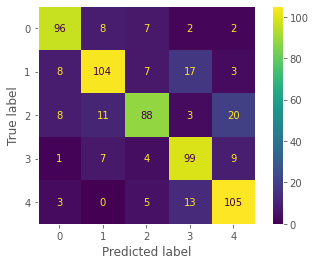

In [16]:
cm = confusion_matrix(eval(mejor_modelo[10]), y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()
plt.grid(None)
plt.show()

Finalmente, se calcula el score (f1-macro en este caso)

In [17]:
score = (f1_score(eval(mejor_modelo[10]), y_pred, average='macro'))
score

0.7813347755175316

Se crea un dataframe donde se almacenarán los resultados de cada modelo a modo de resúmen

In [18]:
resumen = pd.DataFrame({"Modelo":["Random Forest"], "Score_f1-macro":[score], "Modelo_Final":['modelo_final_RF']})

### Predicciones con datos balanceados

Como se comentaba al principio de este documento, los datos mostraban un lijero balanceo, es decir, hay clases que contienen más datos que otras, aunque no en gran medida. Una vez se han obtenido los resultados sin tener en cuenta esto, pueden realizarse algunas pruebas para comprobar si se mejora la predicción del modelo. 
Se realizará:  

1- Se aplicará el modelo Balanced Random Forest de la librería Imbalanced Learn ([info](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html?highlight=random%20fores#imblearn.ensemble.BalancedRandomForestClassifier))  

2- Se aplicará SMOTE (over-sampling) en los datos, de forma que todas las clases tengan la misma representación ([info](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html))


### 1- Balanced Random Forest

Una de las primeras pruebas a realizar será la utilizacion de Balanced Random Forest Classifier de la libreria Imbalanced Learn. Para ello se utilizan los mismos datos anteriores pero esta vez, en la llamada a la función se enviará este método. Debido a que los pasos a realizar son los mismos o similares a los aplicados en Random Forest anterior, se obvian las explicaciones de cada paso.

In [19]:
# Generar modelo con los datos con outliers
mejor_con_outliers = crear_modelos(x_train, y_train, x_test, y_test, BalancedRandomForestClassifier)
mejor_con_outliers[['x_train','y_train','x_test','y_test']]= 'x_train', 'y_train', 'x_test', 'y_test'

# Generar modelo con los datos sin outliers
mejor_sin_outliers = crear_modelos(xso_train, yso_train, xso_test, yso_test, BalancedRandomForestClassifier)
mejor_sin_outliers[['x_train','y_train','x_test','y_test']]= 'xso_train', 'yso_train', 'xso_test', 'yso_test' 

# Dataframe con los mejores resultados de cada modelo
resultado_modelos = pd.concat([mejor_con_outliers, mejor_sin_outliers]).reset_index(drop=True)
resultado_modelos

,index,criterion,max_depth,max_features,min_samples_split,n_estimators,f1,x_train,y_train,x_test,y_test
0,159,gini,100.0,4,4,100,0.786307,x_train,y_train,x_test,y_test
1,190,gini,200.0,4,2,150,0.769902,xso_train,yso_train,xso_test,yso_test


In [20]:
# Se escoge el mejor de los 2 modelos
mejor_modelo = resultado_modelos.loc[resultado_modelos['f1'].idxmax()]
mejor_modelo

index                     159
criterion                gini
max_depth               100.0
max_features                4
min_samples_split           4
n_estimators              100
f1                   0.786307
x_train               x_train
y_train               y_train
x_test                 x_test
y_test                 y_test
Name: 0, dtype: object

In [21]:
# Se evalúa si max_depth contiene nan
if np.isnan(mejor_modelo['max_depth']):
    mejor_modelo['max_depth'] = None
    
# Seleccion del modelo final
modelo_final_BRF = BalancedRandomForestClassifier(criterion=mejor_modelo['criterion'],
                                     max_depth=int(mejor_modelo['max_depth']),
                                     max_features=mejor_modelo['max_features'],
                                     min_samples_split=mejor_modelo['min_samples_split'],
                                     n_estimators=mejor_modelo['n_estimators'],
                                     n_jobs=-1,
                                     random_state=42,
                                     oob_score=False)

# Entreno y predicciones del modelo final
modelo_final_BRF.fit(eval(mejor_modelo[7]), eval(mejor_modelo[8]))
y_pred = modelo_final_BRF.predict(eval(mejor_modelo[9]))

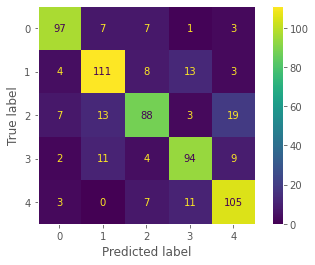

In [22]:
# Matriz de confusion
cm = confusion_matrix(eval(mejor_modelo[10]), y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()
plt.grid(None)
plt.show()

In [23]:
# Se presenta el score obtenido y se guarda en el dataframe de resumen
score = (f1_score(eval(mejor_modelo[10]), y_pred, average='macro'))
resumen.loc[1] = ["Balanced Random Forest", score, 'modelo_final_BRF'] 
score

0.786307317980363

### 2- Smote

In [24]:
# Se aplica la técnica tanto a los datos con outliers como a los que no tienen
smote = SMOTE(random_state=42)
X_smote, y_smote =smote.fit_resample(X, y)
X_so_smote, y_so_smote = smote.fit_resample(X_so, y_so)
print(f"Tamaño de los datos con outliers una vez hecho el resample: {Counter(y_smote)}")
print(f"Tamaño de los datos sin outliers una vez hecho el resample: {Counter(y_so_smote)}")

Tamaño de los datos con outliers una vez hecho el resample: Counter({4: 427, 0: 427, 1: 427, 3: 427, 2: 427})
Tamaño de los datos sin outliers una vez hecho el resample: Counter({4: 418, 0: 418, 1: 418, 3: 418, 2: 418})


In [25]:
# Con Outliers
x_train, x_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42)
print(f"Con outliers -> x_train:{x_train.shape} -- x_test:{x_test.shape} -- y_train:{y_train.shape} -- y_test:{y_test.shape}")
# Sin Outliers
xso_train, xso_test, yso_train, yso_test = train_test_split(X_so_smote, y_so_smote, test_size=0.3, random_state=42)
print(f"Con outliers -> x_train:{xso_train.shape} -- x_test:{xso_test.shape} -- y_train:{yso_train.shape} -- y_test:{yso_test.shape}")

Con outliers -> x_train:(1494, 6) -- x_test:(641, 6) -- y_train:(1494,) -- y_test:(641,)
Con outliers -> x_train:(1463, 6) -- x_test:(627, 6) -- y_train:(1463,) -- y_test:(627,)


In [26]:
# Generar modelo con los datos con outliers
mejor_con_outliers = crear_modelos(x_train, y_train, x_test, y_test, RandomForestClassifier)
mejor_con_outliers[['x_train','y_train','x_test','y_test']]= 'x_train', 'y_train', 'x_test', 'y_test'

# Generar modelo con los datos sin outliers
mejor_sin_outliers = crear_modelos(xso_train, yso_train, xso_test, yso_test, RandomForestClassifier)
mejor_sin_outliers[['x_train','y_train','x_test','y_test']]= 'xso_train', 'yso_train', 'xso_test', 'yso_test' 

# Dataframe con los mejores resultados de cada modelo
resultado_modelos = pd.concat([mejor_con_outliers, mejor_sin_outliers]).reset_index(drop=True)
resultado_modelos

,index,criterion,max_depth,max_features,min_samples_split,n_estimators,f1,x_train,y_train,x_test,y_test
0,255,entropy,10.0,3,3,100,0.776991,x_train,y_train,x_test,y_test
1,15,gini,NaN,4,4,100,0.776653,xso_train,yso_train,xso_test,yso_test


In [27]:
# Se escoge el mejor de los 2 modelos
mejor_modelo = resultado_modelos.loc[resultado_modelos['f1'].idxmax()]
mejor_modelo

index                     255
criterion             entropy
max_depth                10.0
max_features                3
min_samples_split           3
n_estimators              100
f1                   0.776991
x_train               x_train
y_train               y_train
x_test                 x_test
y_test                 y_test
Name: 0, dtype: object

In [28]:
# Se evalúa si max_depth contiene nan
if np.isnan(mejor_modelo['max_depth']):
    mejor_modelo['max_depth'] = None
    
# Seleccion del modelo final
modelo_final_S = RandomForestClassifier(criterion=mejor_modelo['criterion'],
                                     max_depth=int(mejor_modelo['max_depth']),
                                     max_features=mejor_modelo['max_features'],
                                     min_samples_split=mejor_modelo['min_samples_split'],
                                     n_estimators=mejor_modelo['n_estimators'],
                                     n_jobs=-1,
                                     random_state=42,
                                     oob_score=False)

# Entreno y predicciones del modelo final
modelo_final_S.fit(eval(mejor_modelo[7]), eval(mejor_modelo[8]))
y_pred = modelo_final_S.predict(eval(mejor_modelo[9]))

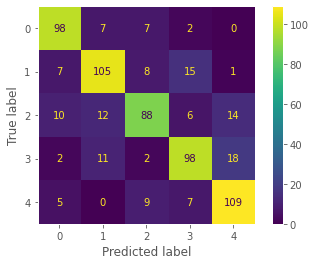

In [29]:
# Matriz de confusión
cm = confusion_matrix(eval(mejor_modelo[10]), y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()
plt.grid(None)
plt.show()

In [30]:
# Se representa el score y se almacena en el dataframe de resúmen
score = (f1_score(eval(mejor_modelo[10]), y_pred, average='macro'))
resumen.loc[2] = ["SMOTE", score, "modelo_final_S"]
score

0.7769910088111299

Una vez obtenidos los resultados de los 3 modelos, se visualizan los resultados a modo de resumen

In [31]:
# Se visualiza el resumen de los datos
resumen = resumen.sort_values('Score_f1-macro', ascending=False).reset_index(drop=True)
resumen

,Modelo,Score_f1-macro,Modelo_Final
0,Balanced Random Forest,0.786307,modelo_final_BRF
1,Random Forest,0.781335,modelo_final_RF
2,SMOTE,0.776991,modelo_final_S


### Prediccion en los datos de test

Para la prediccion, se utilizará el modelo que corresponde con la primera fila del dataset, ya que se han ordenado en función del score f1-macro

In [32]:
# Se cargan los datos de test y se calculan las predicciones
test = pd.read_csv("jm_X_test.csv")
predicciones = eval(resumen['Modelo_Final'][0]).predict(test)

Para finalizar, se genera un dataframe con las predicciones

In [41]:
df_pred = pd.DataFrame(predicciones, columns=['target'])
df_pred.to_csv("erupciones_volcanicas.csv", index=False, header="target")
df_pred.to_json("eurpciones.json")